# Automatic detection of motion artefacts in the ECG signal from a wearable sensor using methods of artificial intelligence

In [12]:
import os
from itertools import product
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import tensorflow as tf

import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, BatchNormalization, concatenate
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Set locale to German to get comma decimal separator
import locale
locale.setlocale(locale.LC_NUMERIC, ('de_DE', 'UTF-8'))

'de_DE.UTF-8'

## Helper functions

In [2]:
'''
    Plots training and validation progress
'''
def plot_metrics(history, metric):
    train = history.history[metric]
    val = history.history['val_' + str(metric)]

    plt.figure(figsize=(10, 5))
    
    plt.plot(train, label='Training ' + str(metric), color='blue')
    plt.plot(val, label='Validation ' + str(metric), color='red')
    
    plt.title('Training and validation ' + str(metric))
    plt.xlabel('Epoch')
    plt.ylabel(str(metric).capitalize())
    
    plt.legend()
    plt.show()

In [3]:
'''
    Plots confusion matrix for multi class classification
'''
def plot_confusion_matrix(y_test, y_pred, class_labels, title, plot=True):
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    plt.rcParams['axes.formatter.use_locale'] = True

    conf_mat = confusion_matrix(np.array(y_test), np.array(y_pred))

    # Normalize confusion matrix to show percentages
    conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6), dpi = 600)
     
    sns.heatmap(conf_mat_norm, 
                annot=True, 
                fmt='.2%', 
                cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                ax=ax
               )
    
    # Format the text correctly
    for text in ax.texts:
        label = text.get_text().replace('.', ',')
        text.set_text(label)
        
    colorbar = ax.collections[0].colorbar
    colorbar.ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_title(title, fontsize=16)
    
    if plot:
        plt.show()
    
    return fig

In [4]:
'''
    Performs train-test-validation split, making sure the data is stratified
'''
def train_test_validation_split(df_norm, df_fft, target, validation=True):
    X = df_norm.drop(['activity', 'artefact'], axis=1).copy()
    X_fft = df_fft.drop(['activity', 'artefact', 'electrode'], axis=1).copy()

    y = df_norm[target].copy()

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40, stratify = y)
    
    # Train validation split - 0.125 x 0.8 = 0.1
    if validation:
        X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                          y_train, 
                                                          test_size = 0.125,      
                                                          random_state = 40, 
                                                          stratify = y_train)
    else:
        X_val = pd.DataFrame()
        y_val = pd.DataFrame()

    # Take the same split from fft dataframe
    X_train_fft = X_fft.iloc[X_train.index]
    X_test_fft = X_fft.iloc[X_test.index]
    X_val_fft = X_fft.iloc[X_val.index]
    
    return X_train, X_test, X_val, X_train_fft, X_test_fft, X_val_fft, y_train, y_test, y_val

In [5]:
'''
    Separates electrode input from ECG input
'''
def get_electrode_input(X_train, X_test, X_val):
    X_train_el = X_train['electrode']
    X_train = X_train.drop(['electrode'], axis=1)
    
    X_test_el = X_test['electrode']
    X_test = X_test.drop(['electrode'], axis=1)
    
    if not X_val.empty:
        X_val_el = X_val['electrode']
        X_val = X_val.drop(['electrode'], axis=1)
    else:
        X_val_el = pd.DataFrame()
    
    return X_train, X_test, X_val, X_train_el, X_test_el, X_val_el

In [6]:
'''
    Checks if the data was split correctly - dataset indices match
'''
def check_index(X_train, X_test, X_val, X_train_fft, X_test_fft, X_val_fft, y_train, y_test, y_val):
    print('Train dataset indices match:      ', X_train.index.equals(X_train_fft.index) and 
                                                X_train.index.equals(y_train.index))

    print('Test dataset indices match:       ', X_test.index.equals(X_test_fft.index) and
                                                X_test.index.equals(y_test.index))

    print('Validation dataset indices match: ', X_val.index.equals(X_val_fft.index) and
                                                X_val.index.equals(y_val.index))

## Metrics

In [7]:
'''
    Get sensitivity, specificity and precision for categories 1 and 4
'''
def log_specificity_sensitifity(y_test, y_pred, run, name):
    TP_1 = np.sum((y_pred[y_test == 1] == 1))
    FP_1 = np.sum((y_pred[y_test != 1] == 1))
    FN_1 = np.sum((y_pred[y_test == 1] != 1))
    TN_1 = np.sum((y_pred[y_test != 1] != 1))

    TP_4 = np.sum((y_pred[y_test == 4] == 4))
    FP_4 = np.sum((y_pred[y_test != 4] == 4))
    FN_4 = np.sum((y_pred[y_test == 4] != 4))
    TN_4 = np.sum((y_pred[y_test != 4] != 4))

    # Calculate sensitivity (recall)
    sensitivity_1 = TP_1 / (TP_1 + FN_1)
    sensitivity_4 = TP_4 / (TP_4 + FN_4)

    # Calculate specificity
    specificity_1 = TN_1 / (TN_1 + FP_1)
    specificity_4 = TN_4 / (TN_4 + FP_4)
    
    # Calculate precision
    precision_1 = TP_1 / (TP_1 + FP_1)
    precision_4 = TP_4 / (TP_4 + FP_4)
    
    run["eval/sensitivity_1_" + name] = sensitivity_1
    run["eval/specificity_1_" + name] = specificity_1
    run["eval/precision_1_" + name] = precision_1
    
    run["eval/sensitivity_4_" + name] = sensitivity_4
    run["eval/specificity_4_" + name] = specificity_4
    run["eval/precision_4_" + name] = precision_4

In [8]:
'''
    Merges predictions for categories 2 and 3
'''
def evaluate_three_categories(y_test, y_pred, run, plot=True):
    y_test_merged = np.where((y_test == 2) | (y_test == 3), 2, y_test)
    y_pred_merged = np.where((y_pred == 2) | (y_pred == 3), 2, y_pred)

    # Reevaluate confusion matrix on the modified data
    class_labels = ['1', '2 a 3', '4']

    fig = plot_confusion_matrix(y_test_merged, y_pred_merged, class_labels, 
                                'Klasifikácia pohybových artefaktov', plot)
    
    log_specificity_sensitifity(y_test_merged, y_pred_merged, run, 'merged')
    
    accuracy = accuracy_score(y_test_merged, y_pred_merged)
    
    return fig, accuracy

In [9]:
'''
    Merges predictions for categories 1, 2 and 3, measures HR detection
'''
def evaluate_heart_rate_categories(y_test, y_pred, run, plot=True):
    y_test_merged = np.where((y_test == 1) | (y_test == 2) | (y_test == 3), 1, y_test)
    y_pred_merged = np.where((y_pred == 1) | (y_pred == 2) | (y_pred == 3), 1, y_pred)

    # Reevaluate confusion matrix on the modified data
    class_labels = ['Čitateľný', 'Nečitateľný']

    fig = plot_confusion_matrix(y_test_merged, y_pred_merged, class_labels, 
                                'Klasifikácia srdečného rytmu', plot)
    
    log_specificity_sensitifity(y_test_merged, y_pred_merged, run, 'HR')

    accuracy = accuracy_score(y_test_merged, y_pred_merged)
    
    return fig, accuracy

## Dataset creation
- Traverse the data directory to create data file - label file pairs
- Go through all of the pairs and construct the output dataframe - extract corresponding segment from signal and include labels
- Check if the dataset is well balanced both in terms of artefact and activity type

In [10]:
PARENT_DIR = '../../data'

ACTIVITIES_NUM = 5               # Number of activity type classes
ARTEFACT_NUM = 4                 # Number of artefact type classes

SEG_LEN_SEC = 2
FS = 500

ECG_LEN = FS * SEG_LEN_SEC       # Size of ECG signal input

FFT_LEN = 200                    # Size of FFT spectrum input

In [11]:
'''
    Create data-label file pairs from the parent path
'''
def create_data_label_pairs():
    data_label_pairs = {}

    # Traverse all ID directories to get the data-label file pairs
    for id_dir in os.listdir(PARENT_DIR):
        data_dir = os.path.join(PARENT_DIR, id_dir)

        # Check if the path is a directory
        if os.path.isdir(data_dir):
            labels_dir = os.path.join(data_dir, 'labels')

            # Double check that data and labels subdirectories exist
            if os.path.exists(data_dir) and os.path.exists(labels_dir):

                # Iterate over .csv files in data directory
                for data_file in os.listdir(data_dir):
                    if data_file.endswith('.csv'):

                        # Check if corresponding label file exists
                        label_file_name = data_file.split('.')[0] + '_' + str(SEG_LEN_SEC) + '.csv'

                        label_path = os.path.join(labels_dir, label_file_name)
                        data_path = os.path.join(data_dir, data_file)

                        if os.path.exists(data_path) and os.path.exists(label_path):
                            data_label_pairs[data_path] = label_path
                            
    return data_label_pairs

data_label_pairs = create_data_label_pairs()

In [13]:
'''
    Create dataframe from data-label file pairs
'''
def create_dataframe(data_label_pairs):
    df = pd.DataFrame(columns = ['artefact', 'activity', 'electrode', 'subject_id'])
    data = []

    # Iterate over matched data-label pairs
    for data_file, label_file in data_label_pairs.items():
        
        df_data = pd.read_csv(data_file, delimiter=';', names=['timestamp', 'value'])
        df_labels = pd.read_csv(label_file, delimiter=';')

        # Iterate over rows in label file
        for idx, row in df_labels.iterrows():
            
            # Extract segment from data based on start and end indices
            start_idx, end_idx = row['start'], row['end']
            segment = df_data.iloc[start_idx:end_idx]['value'].values

            segment = pd.DataFrame(segment, columns=['segment']).T

            # Add activity_type and artefact_type columns
            segment['activity'] = row['activity']
            segment['artefact'] = row['artifact']
            segment['electrode'] = row['electrode']

            data.append(segment)

    return pd.concat(data, ignore_index=True)

df = create_dataframe(data_label_pairs)
df

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,activity,artefact,electrode
0,2134,2125,2130,2131,2137,2136,2143,2141,2149,2155,...,2060,2055,2053,2054,2046,2042,2043,0,1,1
1,2042,2041,2042,2039,2036,2034,2033,2029,2026,2028,...,2117,2127,2133,2147,2145,2149,2150,0,1,1
2,2148,2149,2150,2154,2154,2157,2161,2165,2164,2153,...,2097,2103,2107,2114,2121,2119,2117,0,1,1
3,2120,2125,2121,2125,2125,2124,2124,2119,2108,2104,...,2272,2273,2275,2275,2277,2278,2281,0,1,1
4,2280,2278,2280,2282,2278,2280,2272,2271,2272,2272,...,2151,2167,2180,2200,2207,2214,2218,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,2612,2614,2591,2535,2445,2311,2143,1956,1744,1522,...,2115,2128,2138,2142,2136,2107,2059,3,2,2
4598,2022,1983,1965,1945,1935,1932,1938,1944,1948,1960,...,2181,2209,2218,2214,2205,2194,2180,3,2,2
4599,2167,2152,2164,2172,2178,2190,2211,2232,2245,2268,...,2031,2015,1973,1915,1828,1710,1577,3,2,2
4600,1427,1256,1067,875,691,526,393,260,186,189,...,2643,2591,2555,2534,2518,2503,2490,3,2,2


In [14]:
df['activity'].value_counts()

2    928
1    927
4    918
3    915
0    914
Name: activity, dtype: int64

In [15]:
df['artefact'].value_counts()

1    2099
2    1696
3     461
4     346
Name: artefact, dtype: int64

## Data preprocessing
- Normalize the data to the range of a 12-bit ADC using min-max normalization
- Create new dataframe containing magnitude spectrum of each ECG segment

In [16]:
drop_columns = ['activity', 'artefact', 'electrode']
min_val, max_val = 0, 4096

# Min-max normalized data
normalized = (df.loc[:, ~df.columns.isin(drop_columns)] - min_val) / (max_val - min_val)

# Apply min-max normalization to each column
df_norm = df.copy()

df_norm.loc[:, ~df_norm.columns.isin(drop_columns)] = normalized
df_norm

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,activity,artefact,electrode
0,0.520996,0.518799,0.520020,0.520264,0.521729,0.521484,0.523193,0.522705,0.524658,0.526123,...,0.502930,0.501709,0.501221,0.501465,0.499512,0.498535,0.498779,0,1,1
1,0.498535,0.498291,0.498535,0.497803,0.497070,0.496582,0.496338,0.495361,0.494629,0.495117,...,0.516846,0.519287,0.520752,0.524170,0.523682,0.524658,0.524902,0,1,1
2,0.524414,0.524658,0.524902,0.525879,0.525879,0.526611,0.527588,0.528564,0.528320,0.525635,...,0.511963,0.513428,0.514404,0.516113,0.517822,0.517334,0.516846,0,1,1
3,0.517578,0.518799,0.517822,0.518799,0.518799,0.518555,0.518555,0.517334,0.514648,0.513672,...,0.554688,0.554932,0.555420,0.555420,0.555908,0.556152,0.556885,0,1,1
4,0.556641,0.556152,0.556641,0.557129,0.556152,0.556641,0.554688,0.554443,0.554688,0.554688,...,0.525146,0.529053,0.532227,0.537109,0.538818,0.540527,0.541504,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,0.637695,0.638184,0.632568,0.618896,0.596924,0.564209,0.523193,0.477539,0.425781,0.371582,...,0.516357,0.519531,0.521973,0.522949,0.521484,0.514404,0.502686,3,2,2
4598,0.493652,0.484131,0.479736,0.474854,0.472412,0.471680,0.473145,0.474609,0.475586,0.478516,...,0.532471,0.539307,0.541504,0.540527,0.538330,0.535645,0.532227,3,2,2
4599,0.529053,0.525391,0.528320,0.530273,0.531738,0.534668,0.539795,0.544922,0.548096,0.553711,...,0.495850,0.491943,0.481689,0.467529,0.446289,0.417480,0.385010,3,2,2
4600,0.348389,0.306641,0.260498,0.213623,0.168701,0.128418,0.095947,0.063477,0.045410,0.046143,...,0.645264,0.632568,0.623779,0.618652,0.614746,0.611084,0.607910,3,2,2


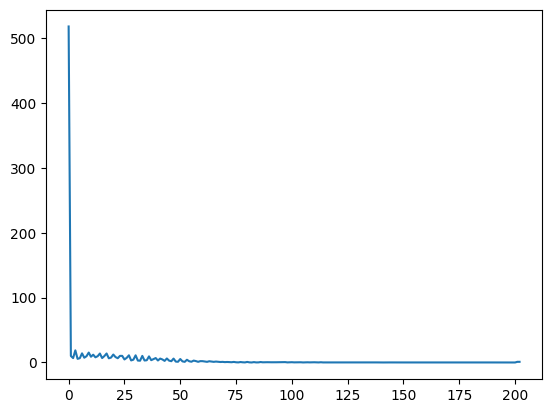

In [17]:
'''
    Create dataframe containing first N points of a spectrum of each ECG segment
'''
def create_fft_dataframe(df, N_freq):    
    ecg_signals = df.iloc[:, :ECG_LEN].values
    
    segment_means = np.mean(ecg_signals, axis=1, keepdims=True)

    # Remove the DC component by subtracting the mean from each segment
#     ecg_signals = ecg_signals - segment_means

    # Compute FFT for each ECG signal
    fft_results = np.abs(np.fft.fft(ecg_signals, axis=1))

    # Extract only the first N frequencies
    fft_magnitudes = fft_results[:, :N_freq]

    activity_types = df['activity'].values.reshape(-1, 1)
    artefact_types = df['artefact'].values.reshape(-1, 1)
    electrode_types = df['electrode'].values.reshape(-1, 1)

    df_fft = np.hstack((fft_magnitudes, artefact_types))

    df_fft = np.hstack((fft_magnitudes, activity_types, artefact_types, electrode_types))
    df_fft = pd.DataFrame(df_fft, columns=[f'fft_{i}' for i in range(N_freq)] + drop_columns)
    
    return df_fft
    
df_fft = create_fft_dataframe(df_norm, FFT_LEN)

# Plot an example FFT spectrum
plt.plot(df_fft.iloc[0].values)
plt.show()

## Artefact classification task

### Train test split
- Split the dataset into training and testing set
- One-hot encode data labels, to match the output shape of the model

In [18]:
(X_train_art, 
X_test_art, 
X_val_art, 
X_train_art_fft, 
X_test_art_fft, 
X_val_art_fft, 
y_train_art, 
y_test_art, 
y_val_art) = train_test_validation_split(df_norm, df_fft, 'artefact', True)

# Get electrode input in the required shape
X_train_art, X_test_art, X_val_art, X_train_art_el, X_test_art_el, X_val_art_el = get_electrode_input(X_train_art, 
                                                                                                      X_test_art, 
                                                                                                      X_val_art)

# One-hot encoding of the output variable
y_train_art_enc = tf.keras.utils.to_categorical(y_train_art - 1, num_classes = ARTEFACT_NUM)
y_val_art_enc = tf.keras.utils.to_categorical(y_val_art - 1, num_classes = ARTEFACT_NUM)

In [19]:
# Check if the indices are equal
check_index(X_train_art, X_test_art, X_val_art, 
            X_train_art_fft, X_test_art_fft, X_val_art_fft, 
            y_train_art, y_test_art, y_val_art)

Train dataset indices match:       True
Test dataset indices match:        True
Validation dataset indices match:  True


In [20]:
# Check if the train data is stratified
y_train_art.value_counts()

1    1469
2    1186
3     323
4     242
Name: artefact, dtype: int64

### Balance dataset

In [21]:
'''
    Function to balance dataframe, will be used after train test split
'''
def balance_dataset(X_train, y_train):
    # Fix random seed so that the same indices are resampled for each dataset
    np.random.seed(50)
    
    train_data = pd.concat([X_train, y_train], axis=1)

    # Separate samples for each value of the artefact column
    artefact_1 = train_data[train_data['artefact'] == 1]
    artefact_2 = train_data[train_data['artefact'] == 2]
    artefact_3 = train_data[train_data['artefact'] == 3]
    artefact_4 = train_data[train_data['artefact'] == 4]

    # Get the size of the majority class
    majority_size = len(artefact_1)

    # Upsample minority classes to match the majority class size
    artefact_2_upsampled = resample(artefact_2, replace = True, n_samples = majority_size)
    artefact_3_upsampled = resample(artefact_3, replace = True, n_samples = majority_size)
    artefact_4_upsampled = resample(artefact_4, replace = True, n_samples = majority_size)
    
    balanced_train_data = pd.concat([artefact_1, artefact_2_upsampled, artefact_3_upsampled, artefact_4_upsampled])

    # Shuffle the training data
    balanced_train_data = balanced_train_data.sample(frac=1)
    
    # Separate the features and target variable for training
    X_train_balanced = balanced_train_data.drop('artefact', axis=1)
    y_train_balanced = balanced_train_data['artefact']
    
    return X_train_balanced, y_train_balanced

In [22]:
X_train_art_bal, y_train_art_bal = balance_dataset(X_train_art, y_train_art)
X_train_art_fft_bal, _ = balance_dataset(X_train_art_fft, y_train_art)

# One-hot encoding of the output variable
y_train_art_enc_bal = tf.keras.utils.to_categorical(y_train_art_bal - 1, num_classes=ARTEFACT_NUM)

y_train_art_bal.value_counts()

4    1469
1    1469
2    1469
3    1469
Name: artefact, dtype: int64

In [23]:
# Check if the indices are equal
check_index(X_train_art_bal, X_test_art, X_val_art, 
            X_train_art_fft_bal, X_test_art_fft, X_val_art_fft, 
            y_train_art_bal, y_test_art, y_val_art)

Train dataset indices match:       True
Test dataset indices match:        True
Validation dataset indices match:  True


### Best model

29/29 [==============================] - 0s 7ms/step


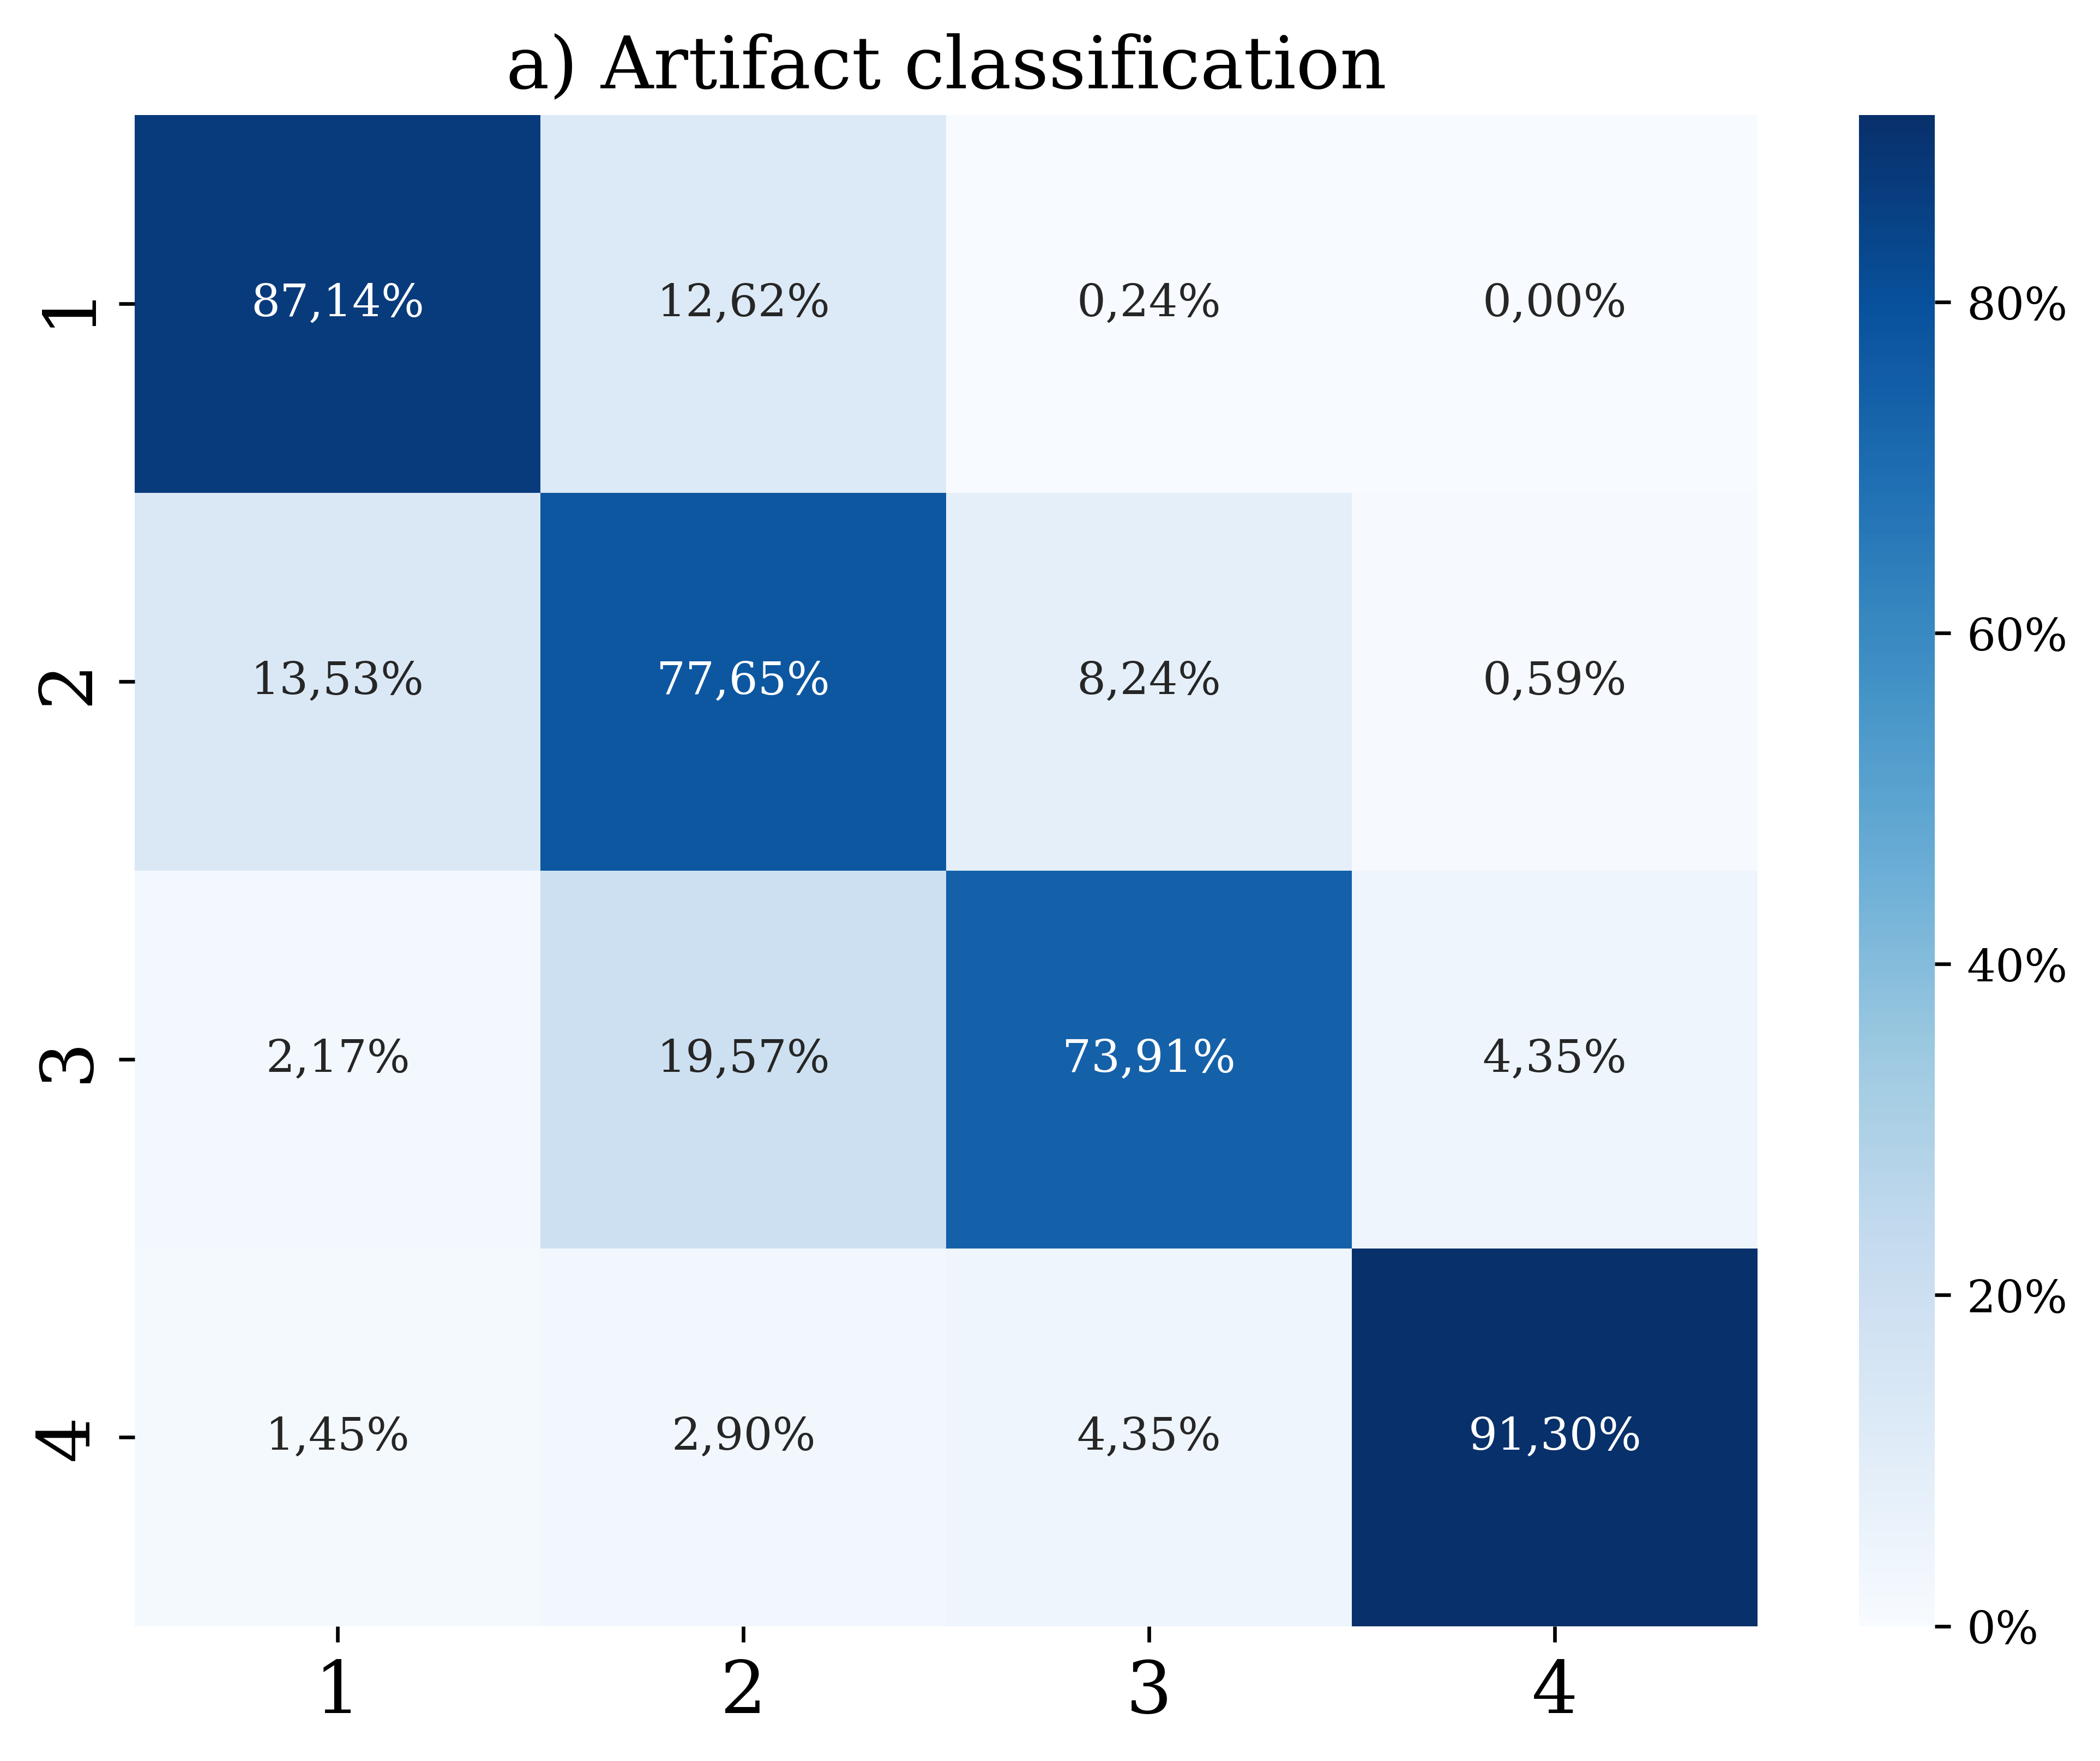

In [24]:
class_labels = ['1', '2', '3', '4']

loaded_model = keras.saving.load_model('models/artefact_classifier.keras')

preds_art = loaded_model.predict([X_test_art, X_test_art_fft, X_test_art_el])
y_pred_art = np.argmax(preds_art, axis=1)

fig = plot_confusion_matrix(y_test_art, y_pred_art + 1, class_labels, 'a) Artifact classification', True)

### Model architectures

In [40]:
params = {
    'epochs': 30,
    'batch_size': 16,
    'learning_rate': 0.0001, 
    'dropout': 0.1,
    'weight_decay': 0.0001,
    'optimizer': 'Adam',
    'hidden_activation': 'relu',
    'output_activation': 'softmax',
    'loss': 'categorical_crossentropy',
    'metric': 'accuracy',
    'kernel_size': 5,
    'pool_size': 2,
}

In [41]:
'''
    Custom learning rate schedule function, reduces learning rate based on epoch number
'''
def lr_schedule(epoch):
    initial_lr = params['learning_rate']
    
    k = 0.1
    return initial_lr * math.exp(-k * epoch)
    
lr_scheduler = LearningRateScheduler(lr_schedule)

In [42]:
'''
    Artefact type classification convolutional model, ECG input together with FFT
'''
def artefact_classifier_conv(ecg_len, fft_len, electrode_len, num_activities):
    # Input layer for ECG segments
    ecg_input = Input(shape=(ecg_len,), name = 'signal_input')
    
    # Input layer for FFT segments
    fft_input = Input(shape=(fft_len,), name = 'frequency_input')
 
    # Input layer for electrode type
    electrode_input = Input(shape=(electrode_len,), name = 'electrode_input')
    
    ecg_dense1 = Dense(512, activation=params['hidden_activation'])(ecg_input)
    
    # Reshape FFT input for convolutional layers
    fft_reshaped = Reshape((fft_len, 1))(fft_input)
    
    # Convolutional layers for FFT      
    conv1 = Conv1D(64, kernel_size = params['kernel_size'], activation = params['hidden_activation'])(fft_reshaped)  
    pool1 = MaxPooling1D(pool_size = 2)(conv1)
    
    conv2 = Conv1D(128, kernel_size = params['kernel_size'], activation = params['hidden_activation'])(pool1)
    pool2 = MaxPooling1D(pool_size = 2)(conv2)

    flatten_fft = Flatten()(pool2)
    
    # Concatenate outputs from dense and convolutional layers
    concatenated = concatenate([ecg_dense1, flatten_fft])
    
    # Fully connected and dropout layers
    dense2 = Dense(512, activation = params['hidden_activation'])(concatenated)
    dropout2 = Dropout(params['dropout'])(dense2)
    
    dense3 = Dense(128, activation = params['hidden_activation'])(dropout2)    
    dropout3 = Dropout(params['dropout'])(dense3)
    
    dense4 = Dense(64, activation=params['hidden_activation'])(dropout3)
    
    # Output layer for activity prediction
    output = Dense(num_activities, activation = params['output_activation'], name = 'output')(dense4)
    
    # Optimizer with weight decay
    opt = Adam(weight_decay = params['weight_decay'])
    
    model = Model(inputs = [ecg_input, fft_input, electrode_input], outputs = output)
    
    model.compile(optimizer = opt, loss = params['loss'], metrics = [params['metric']])
    
    return model

model = artefact_classifier_conv(ECG_LEN, FFT_LEN, 1, ARTEFACT_NUM)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frequency_input (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 reshape_3 (Reshape)         (None, 200, 1)               0         ['frequency_input[0][0]']     
                                                                                                  
 conv1d_6 (Conv1D)           (None, 196, 64)              384       ['reshape_3[0][0]']           
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 98, 64)               0         ['conv1d_6[0][0]']      

### Training

In [43]:
# Init Neptune.ai project
run = neptune.init_run(
    project='veronika.kalouskova/DP-Artefact-Classification',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMTY5NGI5ZS0xNzk1LTQwYjItYjc0Ny1lZWNmZjdjZjg1MzEifQ==',
)

# Log model parameters into Neptune
run['parameters'] = params

# Log model summary and architecture into Neptune
neptune_callback = NeptuneCallback(run=run)

history = model.fit([X_train_art, X_train_art_fft, X_train_art_el],
                    y_train_art_enc, 
                    epochs = params['epochs'], 
                    batch_size = params['batch_size'], 
                    validation_data=([X_val_art, X_val_art_fft, X_val_art_el], y_val_art_enc),
                    callbacks=[neptune_callback, lr_scheduler]
                   )

# Log model architecture and weights into Neptune
model.save('models/model.keras')

run['saved_model'].upload('models/model.keras')

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/veronika.kalouskova/DP-Artefact-Classification/e/DPAR-414
Epoch 1/30
202/202 [==============================] - 9s 39ms/step - loss: 0.9810 - accuracy: 0.5528 - val_loss: 0.8518 - val_accuracy: 0.6052 - lr: 1.0000e-04
Epoch 2/30
202/202 [==============================] - 9s 42ms/step - loss: 0.8121 - accuracy: 0.6323 - val_loss: 0.8075 - val_accuracy: 0.6399 - lr: 9.0484e-05
Epoch 3/30
202/202 [==============================] - 9s 44ms/step - loss: 0.7421 - accuracy: 0.6742 - val_loss: 0.6995 - val_accuracy: 0.7115 - lr: 8.1873e-05
Epoch 4/30
202/202 [==============================] - 8s 38ms/step - loss: 0.6841 - accuracy: 0.6984 - val_loss: 0.6462 - val_accuracy: 0.7202 - lr: 7.4082e-05
Epoch 5/30
202/202 [==============================] - 7s 37ms/step - loss: 0.6548 - accuracy: 0.7168 - val_loss: 0.6421 - val_accuracy: 0.7267 - lr: 6.7032e-05
Epoch 6/30
202/202 [==============================] - 8s 41ms

### Evaluation

29/29 [==============================] - 0s 7ms/step


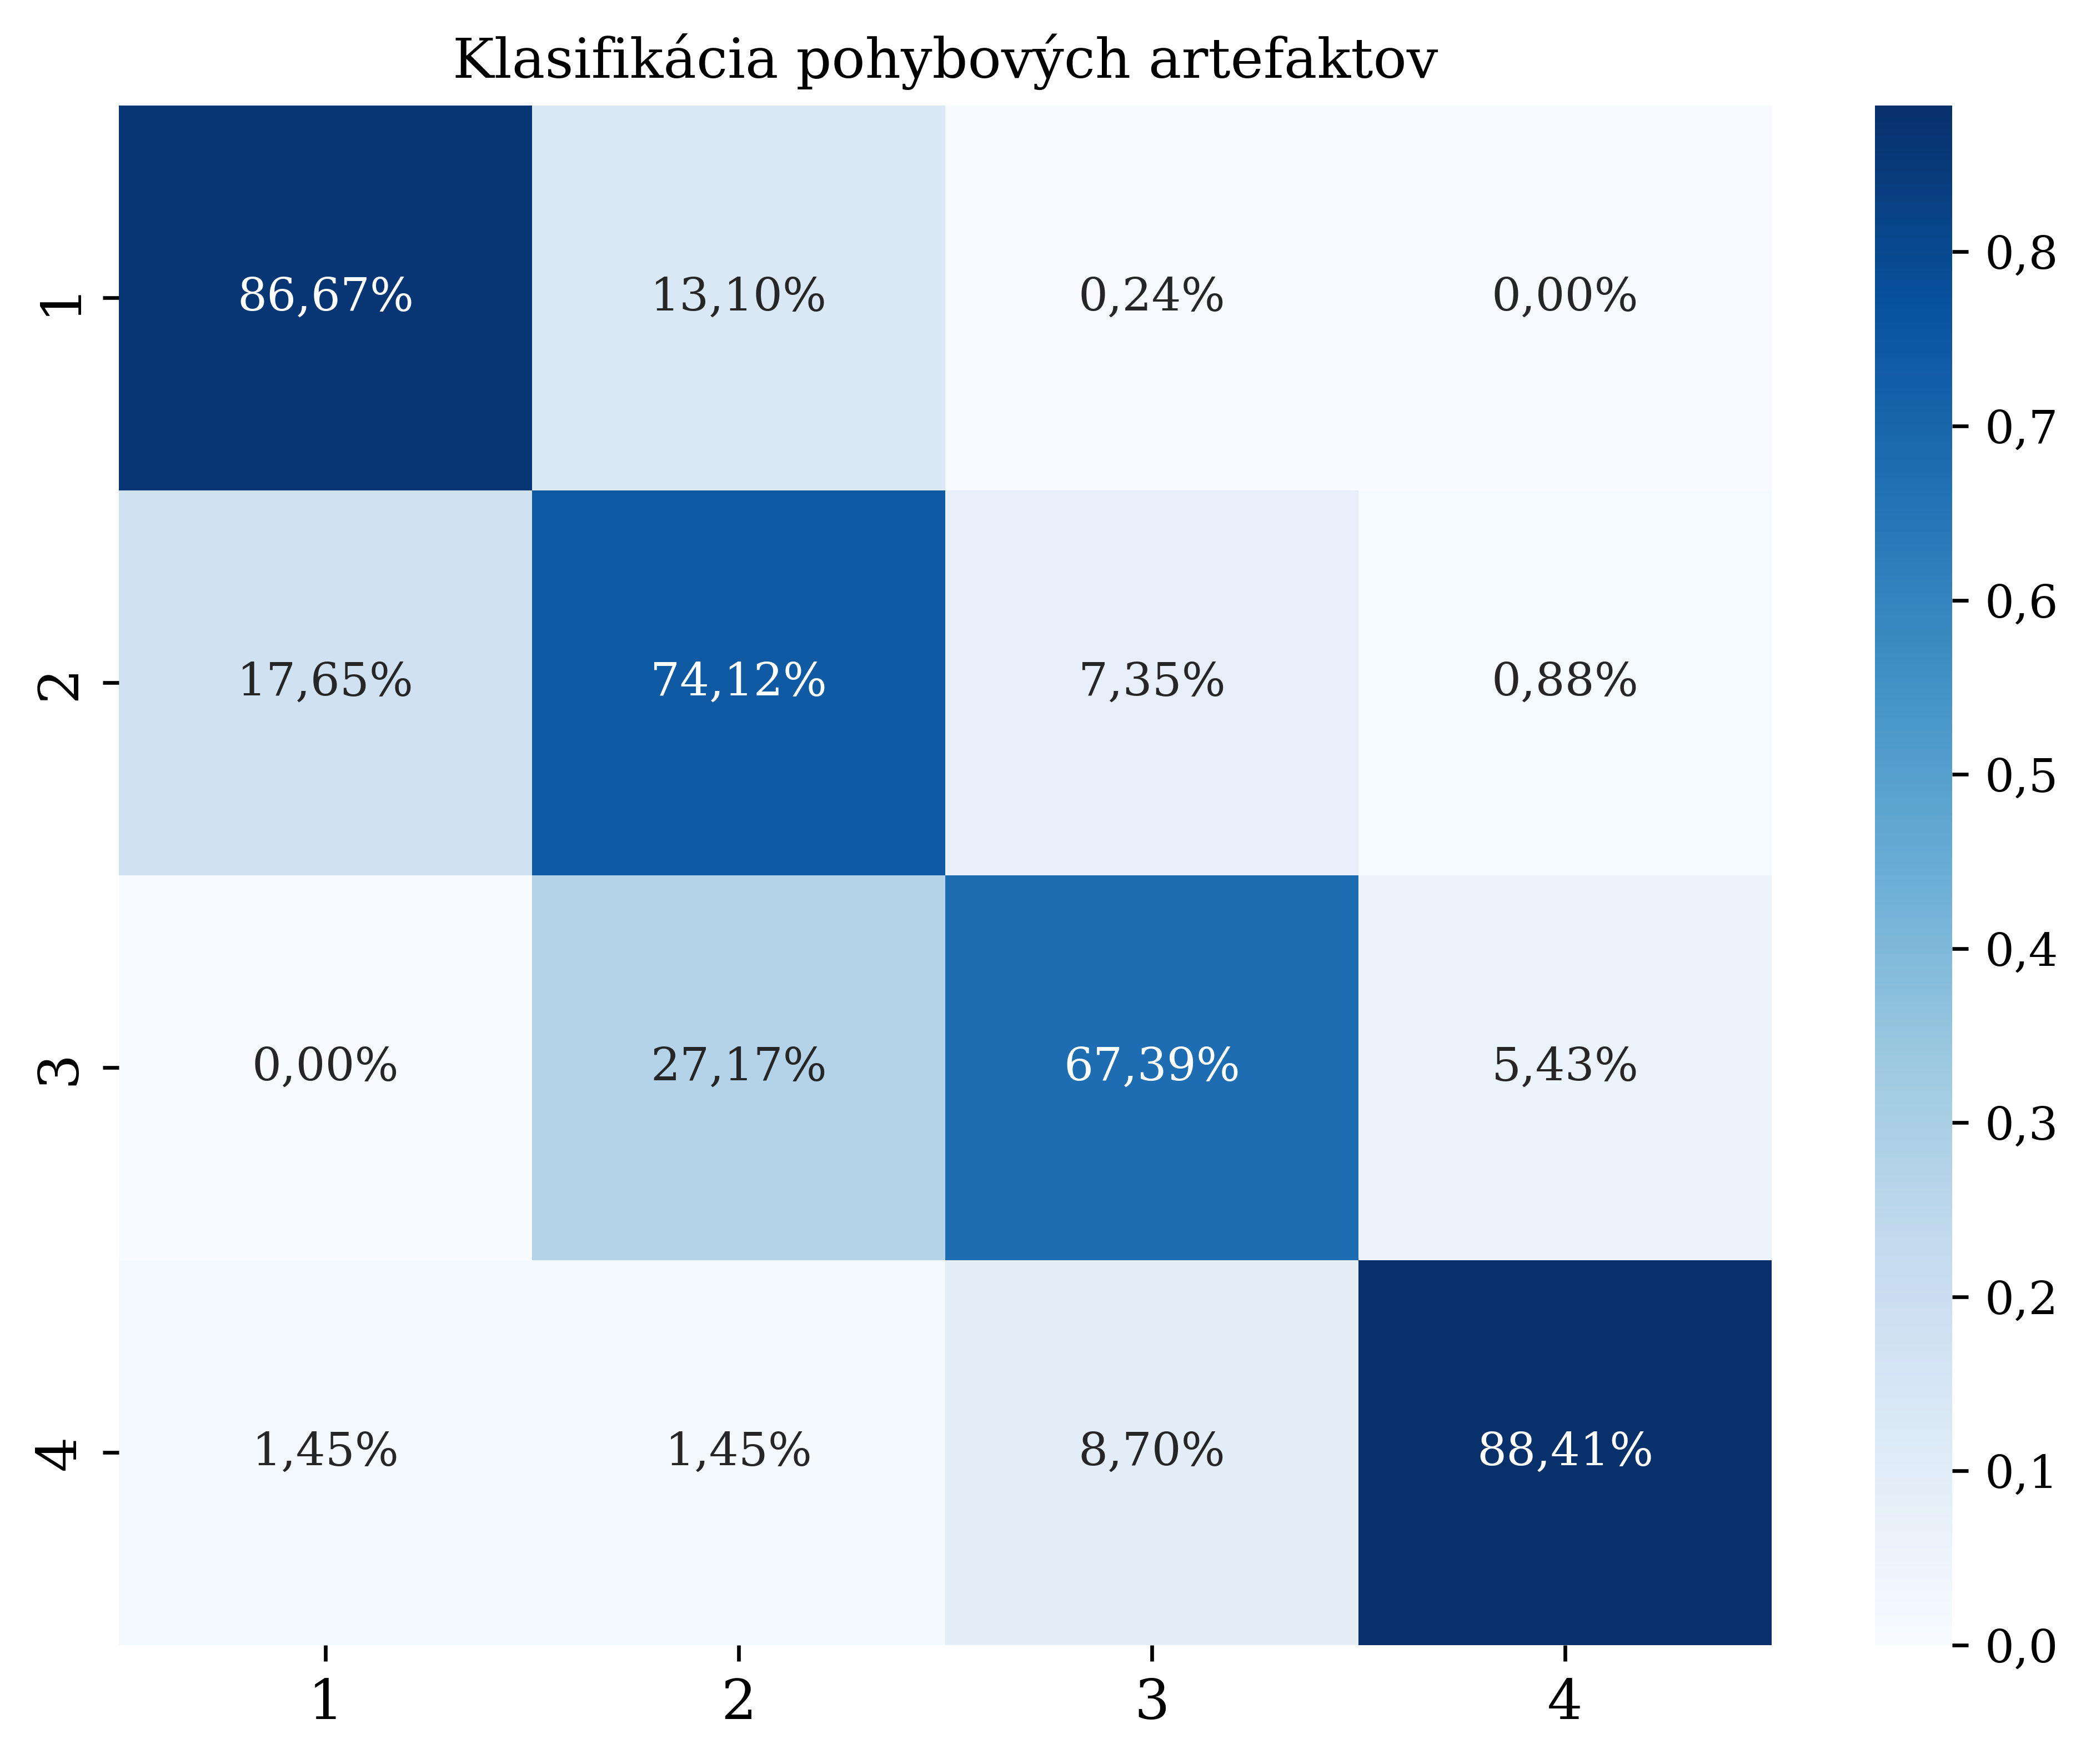

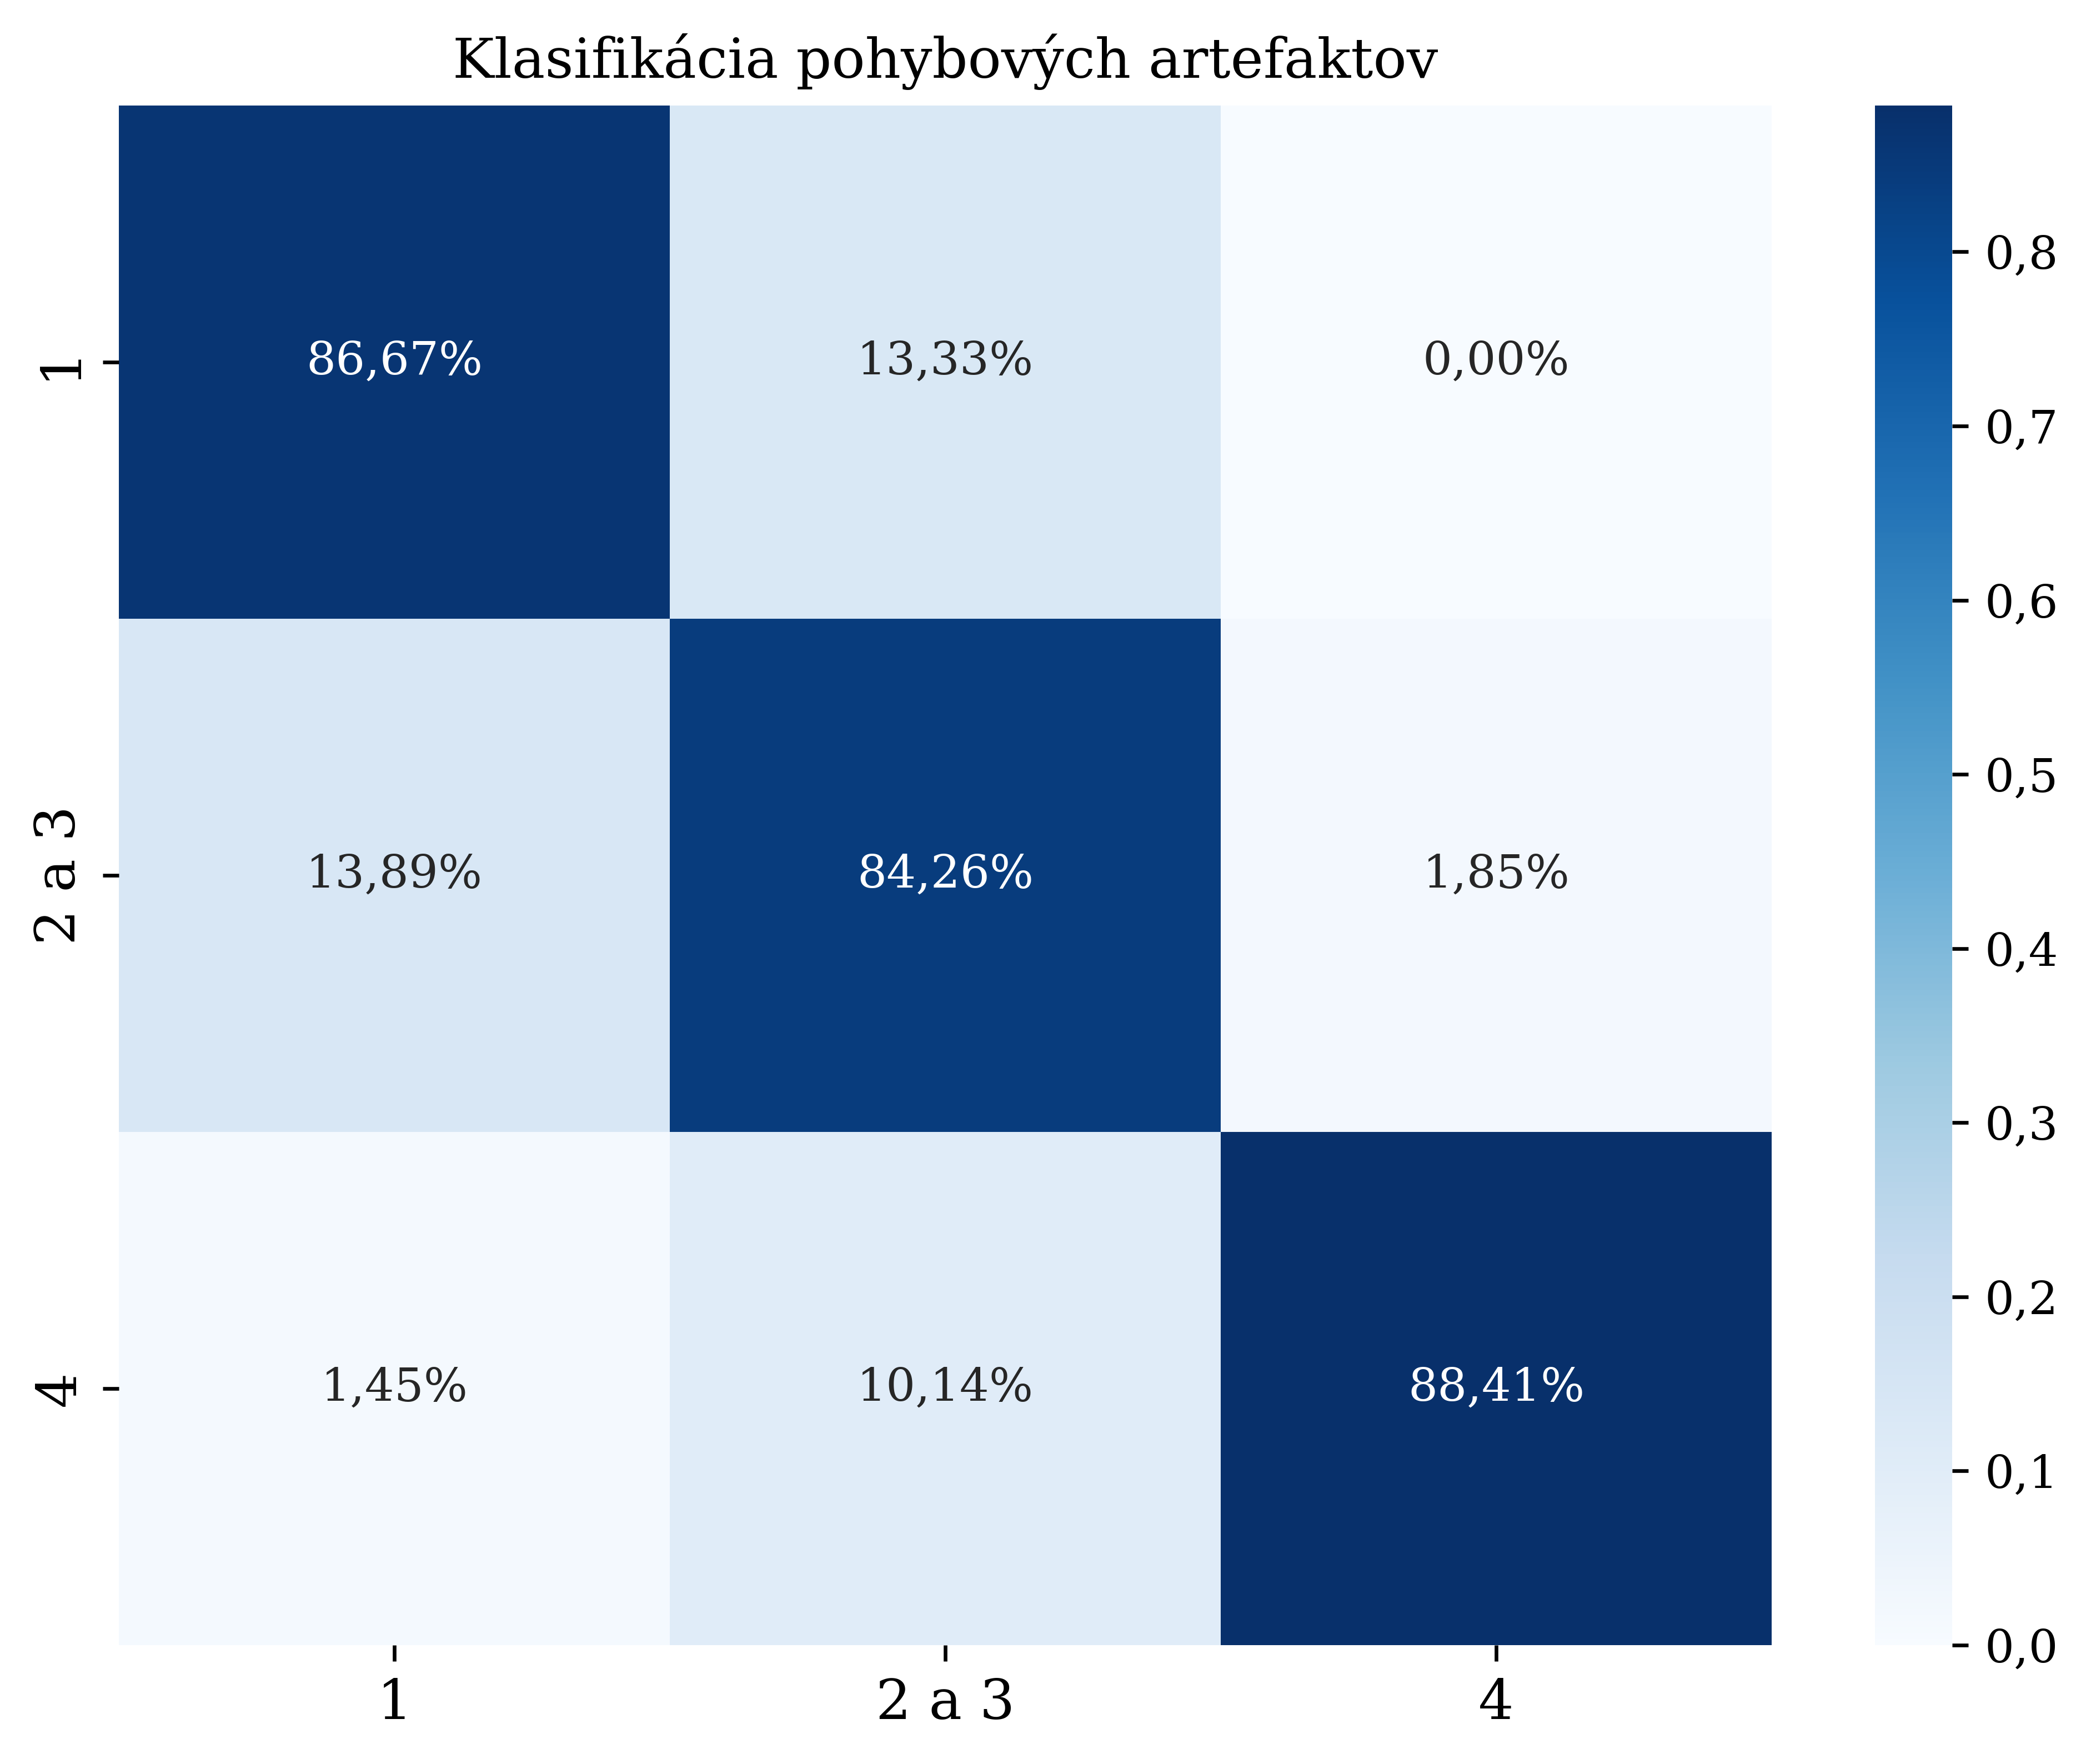

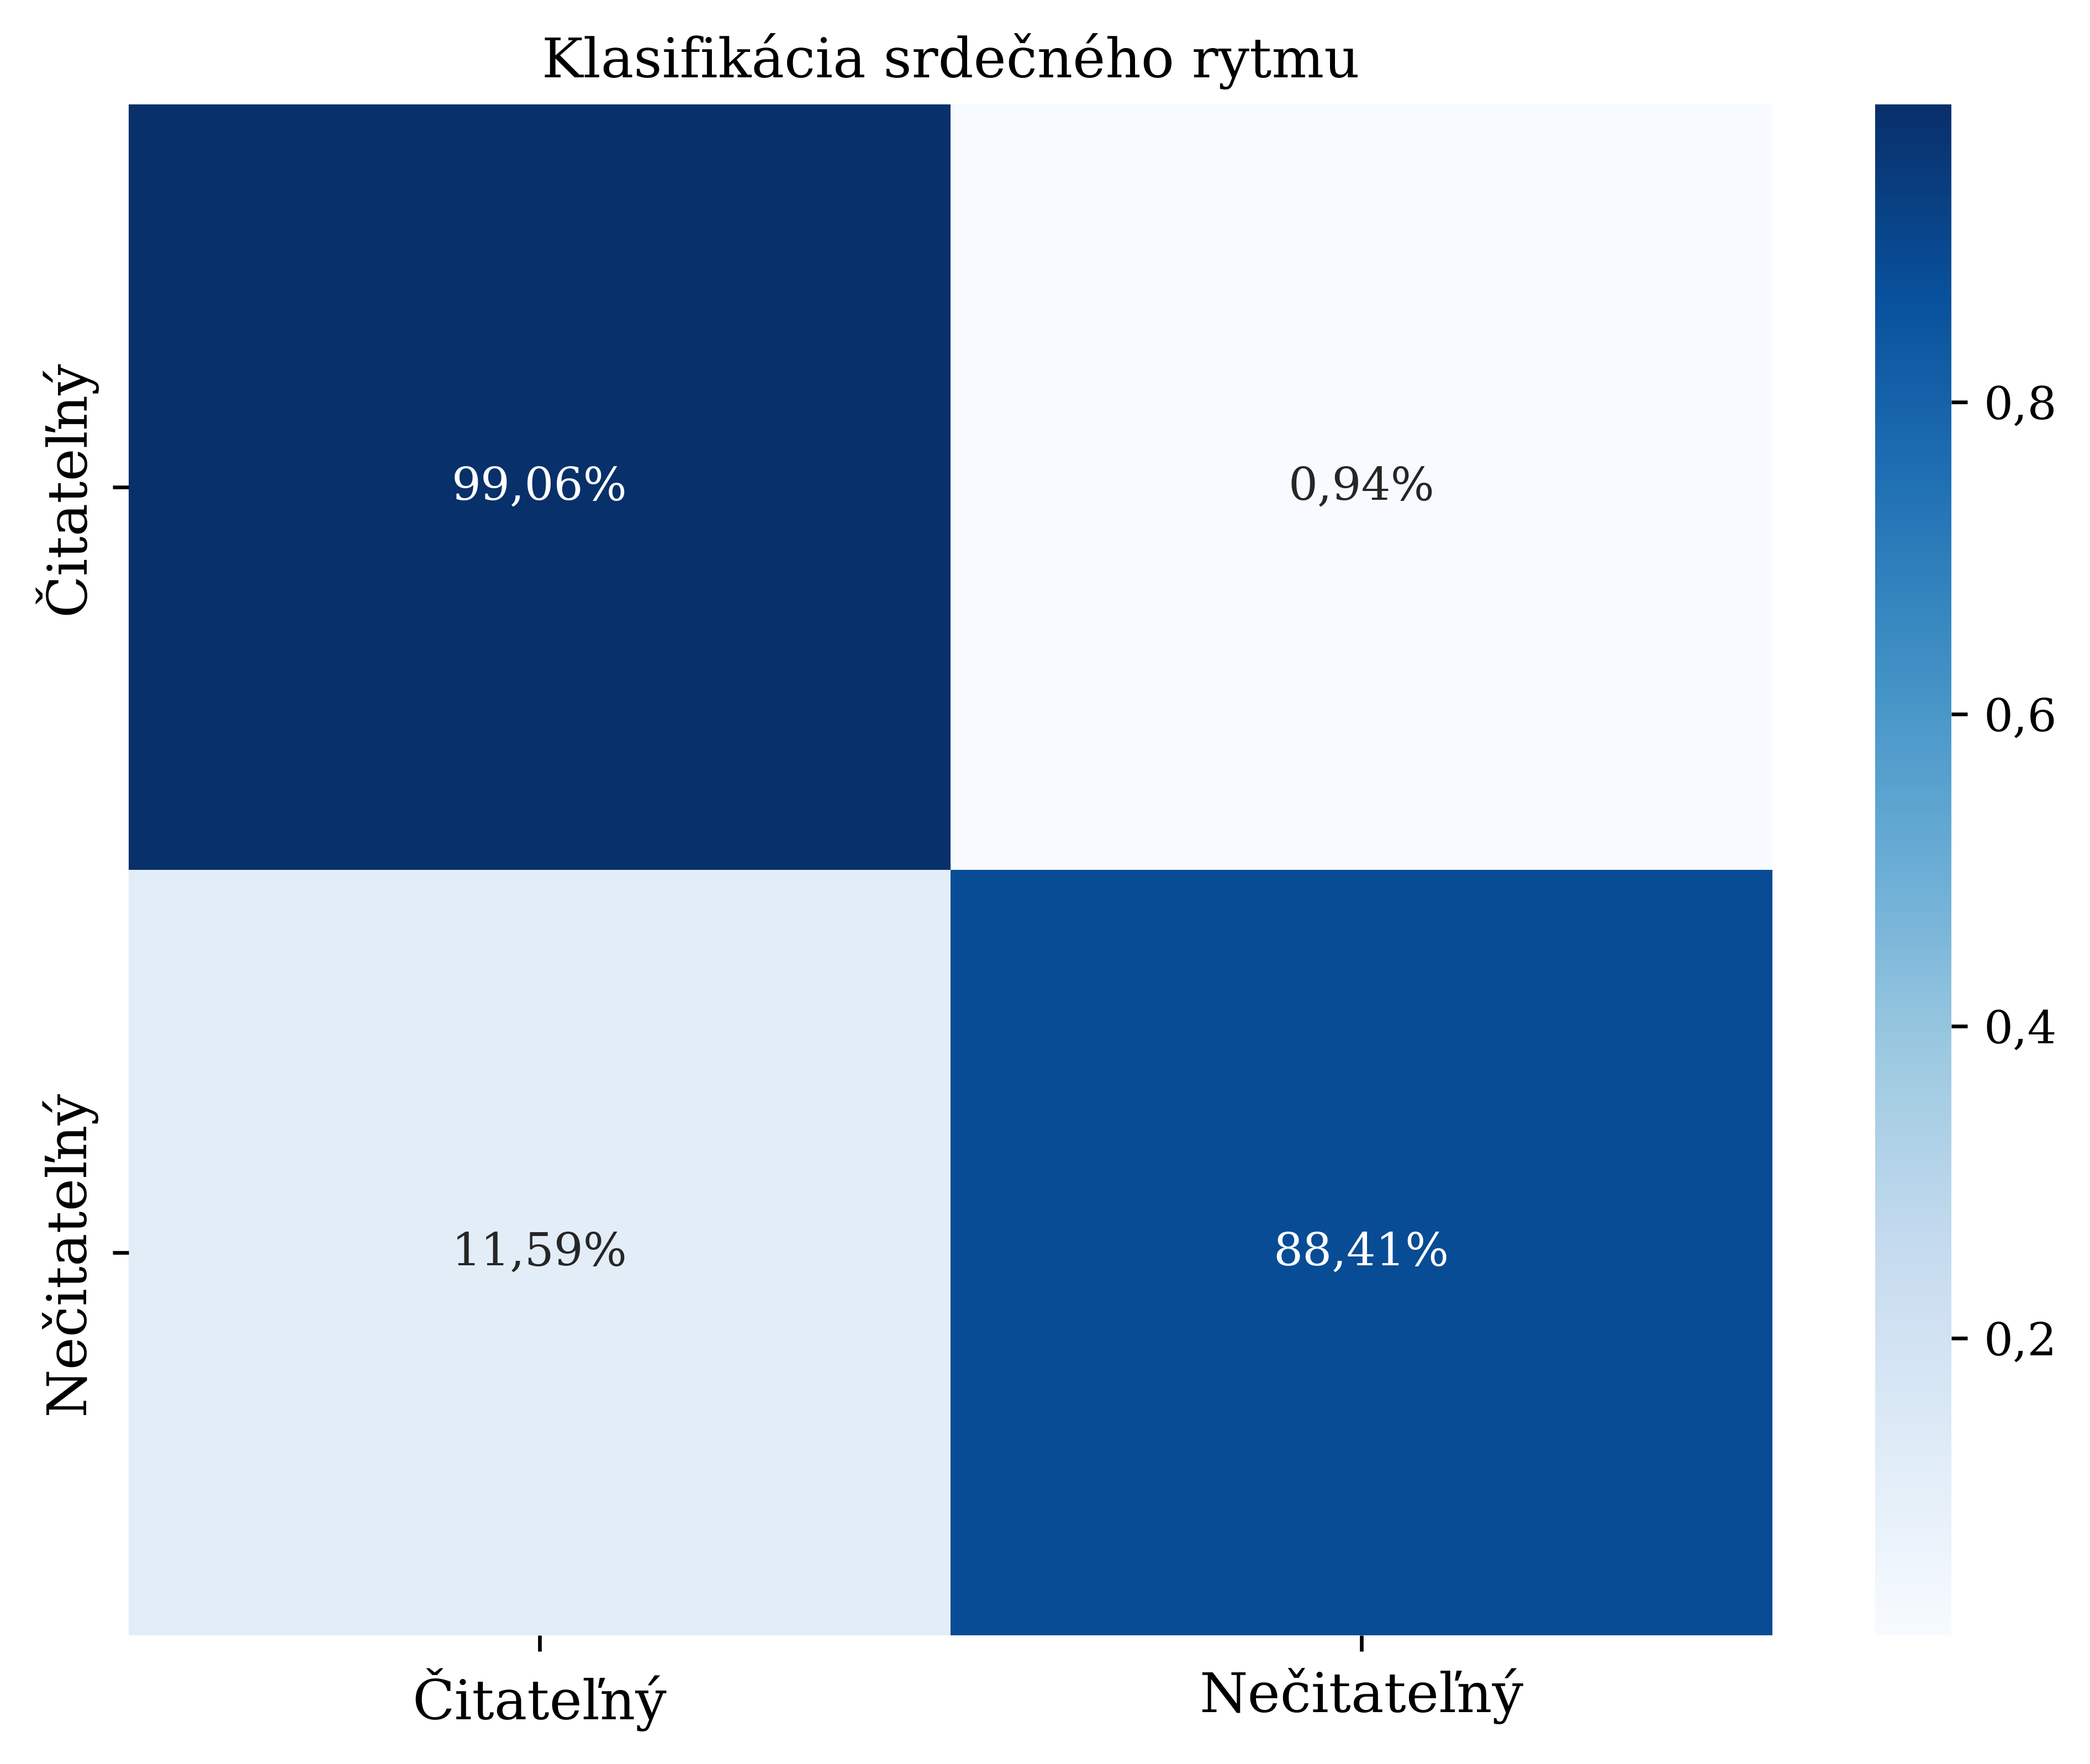

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 30 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 30 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/veronika.kalouskova/DP-Artefact-Classification/e/DPAR-414/metadata


In [44]:
'''
    Evaluates and logs performance for artefact classification
'''
def evaluate_artefact_classification(run, model, plot=True):
    class_labels = ['1', '2', '3', '4']

    preds_art = model.predict([X_test_art, X_test_art_fft, X_test_art_el])
    y_pred_art = np.argmax(preds_art, axis=1) + 1

    # Log data for 4 artefact categories
    accuracy = accuracy_score(y_test_art, y_pred_art)
    run['eval/accuracy'] = accuracy

    log_specificity_sensitifity(y_test_art, y_pred_art, run, '')

    fig = plot_confusion_matrix(y_test_art, y_pred_art, class_labels, 'Klasifikácia pohybových artefaktov', plot)
    run['eval/confusion_matrix'] = fig

    # Log data for 3 artefact categories
    fig, accuracy = evaluate_three_categories(y_test_art, y_pred_art, run, plot)
    run['eval/accuracy_merged'] = accuracy
    run['eval/confusion_matrix_merged'] = fig

    # Log data for 2 artefact categories (HR detection)
    fig, accuracy = evaluate_heart_rate_categories(y_test_art, y_pred_art, run, plot)
    run['eval/accuracy_HR'] = accuracy
    run['eval/confusion_matrix_HR'] = fig

    run.stop()
    
evaluate_artefact_classification(run, model)

### Hyperparameter tuning

In [ ]:
# Define hyperparameters and their possible values
param_grid = {
    'epochs':                 [15],
    'batch_size':             [8, 16, 32],
    'learning_rate':          [0.005, 0.001, 0.0005, 0.0001], 
    'dropout':                [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],                            
    'weight_decay':           [0.0, 0.001, 0.0001],
    'optimizer':              ['Adam'],
    'hidden_activation':      ['relu'],
    'output_activation':      ['softmax'],
    'loss':                   ['categorical_crossentropy'],
    'metric':                 ['accuracy'],
    'kernel_size':            [3, 5, 9],
    'pool_size':              [2, 3]
}
      
grid_search(param_grid, ARTEFACT_NUM, 'veronika.kalouskova/DP-Artefact-Classification', 
            artefact_classifier_conv, evaluate_artefact_classification,
            X_train_art, X_train_art_fft, X_train_art_el, y_train_art_enc,
            X_val_art, X_val_art_fft, X_val_art_el, y_val_art_enc)

### Ensemble bagging

In [ ]:
class_labels = ['1', '2', '3', '4']

ensemble_pred = bagging_ensemble(5, X_train_act, X_train_act_fft, X_train_act_el, y_train_act_enc, 
                                    X_val_act, X_val_act_fft, X_val_act_el, y_val_act_enc, 
                                    X_test_act, X_test_act_fft, X_test_act_el)

accuracy = accuracy_score(y_test_act, ensemble_pred)

# Evaluate results 
fig = plot_confusion_matrix(y_test_act, ensemble_pred + 1, class_labels, 'Klasifikácia pohybovej aktivity')
print('Test accuracy: ', accuracy)